In [111]:
from collections import defaultdict
from functools import reduce
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
import pickle
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from clean import clean
#from augment import augment
from trial import Trial

################################################################################
# Begin global state
################################################################################

facts = pd.read_csv("rst_transitions.tab", sep="\t", quoting=3)

# some categories of columns
lex_feats = ["Top2-Stack", "Top1Span", "First-Queue"]
categorical_features = ['Top12-StackXML', 'Stack-QueueSType', "Stack", "genre", "Stack-QueueSameSent",
                        'Top12-StackSameSent', 'Stack-QueueXML', 'Top12-StackSType',
                        "Top12-StackDir", "Stack-QueueDir", "First-QueueEduFunc", "Top1SpanEduFunc"
                        # added genre
                       ,'genre'
                       ,'SeqPredTop1Span'
                       ]
numeric_features = ['First-QueueDist-To-Begin', 'Top2-StackLength-EDU', 'Top1-StackLength-EDU', 
                    # new
                    #"StackQueueAntonym",
                    #"StackQueueCommonWord"
                   ] #'Top1-StacknEDUs']
scale_features = ['Top2-StackDist-To-End', 'First-Queue-Len']
text_features = ['First-Queue', 'Top1Span', 'Top2-Stack', 'Top1-Stack']
def load_bc():
    with open('bc3200.pickle', 'rb') as f:
        bc3200 = pickle.load(f)   
    # treat something like '10101111' as a binary integer encoding
    s2n = lambda s: sum([int(s[-i]) * (1 << i) for i in range(len(s))])
    
    converted = [(k, s2n(v)) for k,v in bc3200.items()]
    # sort by bc encoding
    return dict(sorted(converted, key=lambda x:x[1]))
bc_dict = load_bc()

# clean data
data = facts.copy(deep=True)
data = clean(data)

In [115]:
# augment
def any_word_in_common(x, col1, col2, tok_counts):
    top_3000_words = [x[0] for x in sorted(tok_counts.items(), key=lambda x:x[1])[:3000]]
    in_common = []
    for i in range(len(x)):
        toks1 = x[col1][i].split(" ")
        toks2 = x[col2][i].split(" ")
        in_common.append(any(w1 == w2 and w1 not in top_3000_words for w1 in toks1 for w2 in toks2))
    return in_common

cache = {}
cache['antonym'] = {}
cache['synonym'] = {}
def find_related_words(word, rtype='antonym'):
    assert rtype in ['antonym', 'synonym']
    related = []
    if word in cache[rtype]:
        return cache[rtype][word]

    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            if rtype == 'antonym' and l.antonyms():
                related.append(l.antonyms()[0].name())
            elif rtype == 'synonym':
                related.append(l.name())

    cache[rtype][word] = related
    return related

lemmatizer = WordNetLemmatizer()
def any_antonyms(x, col1, col2):
    ants_exist = []
    for i in range(len(x)):
        toks1 = x[col1][i].split(" ")
        toks2 = x[col2][i].split(" ")
        ants_1 = reduce(lambda a,b: a + b, [find_related_words(w, rtype='antonym') for w in toks1])
        ants_2 = reduce(lambda a,b: a + b, [find_related_words(w, rtype='antonym') for w in toks2])
        found = False
        for w1 in toks1:
            if not found and lemmatizer.lemmatize(w1) in ants_2:
                ants_exist.append(True)
                found = True
        for w2 in toks2:
            if not found and lemmatizer.lemmatize(w2) in ants_1:
                ants_exist.append(True)
                found = True
        if not found:
            ants_exist.append(False)
        
    return ants_exist

def any_synonyms(x, col1, col2):
    syns_exist = []
    for i in range(len(x)):
        toks1 = x[col1][i].split(" ")
        toks2 = x[col2][i].split(" ")
        syns_1 = reduce(lambda a,b: a + b, [find_related_words(w, rtype='synonym') for w in toks1])
        syns_2 = reduce(lambda a,b: a + b, [find_related_words(w, rtype='synonym') for w in toks2])
        found = False
        for w1 in toks1:
            if not found and lemmatizer.lemmatize(w1) in syns_2:
                syns_exist.append(True)
                found = True
        for w2 in toks2:
            if not found and lemmatizer.lemmatize(w2) in syns_1:
                syns_exist.append(True)
                found = True
        if not found:
            syns_exist.append(False)
        
    return syns_exist

def synonym_count(x, col1, col2):
    counts = []
    for i in range(len(x)):
        count = 0
        toks1 = x[col1][i].split(" ")
        toks2 = x[col2][i].split(" ")
        syns_1 = reduce(lambda a,b: a + b, [find_related_words(w, rtype='synonym') for w in toks1])
        syns_2 = reduce(lambda a,b: a + b, [find_related_words(w, rtype='synonym') for w in toks2])
        for w1 in toks1:
            if lemmatizer.lemmatize(w1) in syns_2:
                count += 1
        for w2 in toks2:
            if lemmatizer.lemmatize(w2) in syns_1:
                count += 1
        counts.append(count)
        
    return counts

def antonym_count(x, col1, col2):
    counts = []
    for i in range(len(x)):
        count = 0
        toks1 = x[col1][i].split(" ")
        toks2 = x[col2][i].split(" ")
        ants_1 = reduce(lambda a,b: a + b, [find_related_words(w, rtype='antonym') for w in toks1])
        ants_2 = reduce(lambda a,b: a + b, [find_related_words(w, rtype='antonym') for w in toks2])
        for w1 in toks1:
            if lemmatizer.lemmatize(w1) in ants_2:
                count += 1
        for w2 in toks2:
            if lemmatizer.lemmatize(w2) in ants_1:
                count += 1
        counts.append(count)
        
    return counts

def count_tokens(x):
    counts = defaultdict(int)
    for i in range(len(x)):
        for col in text_features:
            for tok in x[col][i]:
                counts[tok] += 1
    return counts
               
def augment(data):
    # If you want to engineer some table features
    # before creating a dev partition, this is the place!
    tok_counts = count_tokens(data)
    data["First-Queue-Len"] = data["First-Queue"].str.len()
    data["StackQueueCommonWord"] = any_word_in_common(data, "First-Queue", "Top1-Stack", tok_counts)
    data["StackQueueAntonym"] = any_antonyms(data, "First-Queue", "Top1-Stack")
    data["StackQueueSynonymCount"] = synonym_count(data, "First-Queue", "Top1-Stack")
    return data
data = augment(data)

In [116]:
data = data.sample(frac=1, random_state=42)
def split(data):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in splitter.split(data, data["label"]):
        train = data.loc[train_idx]
        test = data.loc[test_idx]
    return train, test
train, test = split(data)
print(len(train))
pd.set_option('display.max_columns', None)
train.head()

22702


,First-Queue,First-QueueDist-To-Begin,First-QueueEduFunc,First-QueueFullFunc,First-QueueFullPos,Queue,SeqPredFirstSpan,SeqPredTop1Span,Stack,Stack-QueueDir,Stack-QueueSType,Stack-QueueSameSent,Stack-QueueXML,Top1-Stack,Top1-StackDist-To-Begin,Top1-StackDist-To-End,Top1-StackLength-EDU,Top1-StacknEDUs,Top12-StackDir,Top12-StackSType,Top12-StackSameSent,Top12-StackXML,Top1Span,Top1SpanEduFunc,Top1SpanFullFunc,Top1SpanFullPos,Top2-Stack,Top2-StackDist-To-Begin,Top2-StackDist-To-End,Top2-StackLength-EDU,genre,label,First-Queue-Len,StackQueueCommonWord,StackQueueAntonym,StackQueueSynonymCount
19473,# People used to go to banks with gold and receive ' money ' for it . #,103.0,root,# nsubj root mark xcomp case obl case obl cc conj punct obj punct case obl punct #,# NNS VBD TO VB TO NNS IN NN CC VB `` NN '' IN PRP . #,NonEmpty,elabo,attri,MoreElem,NONE_NONE,decl_other,False,<p>__,# it means . #,102,67,1.0,1.0,NONE,other,True,_,# it means . #,ccomp,# nsubj ccomp punct #,# PRP VBZ . #,# the gov't says #,101,68.0,1.0,reddit,attribution-SN,71,True,False,0
4942,# were not only marked by her experience #,94.0,root,# aux:pass advmod advmod root case nmod:poss obl #,# VBD RB RB VBN IN PRP$ NN #,NonEmpty,same,elabo,MoreElem,NONE,decl,True,_,# The stories of her mature period # ( 1894 – 96 ) #,92,31,2.0,13.0,NONE_NONE,decl_decl,False,<p>_<p>,# The stories of her mature period #,nsubj:pass,# det nsubj:pass case nmod:poss amod nmod #,# DT NNS IN PRP$ JJ NN #,"# In 1893 , Higuchi , her mother and her sister abandoned their middle class house # and , with a grim determination # to survive , # moved to a poor neighborhood # where they opened a stationery store # that before long failed . # Their new dwelling was a five-minute walk from Tokyo 's ill-famed red-light district , the Yoshiwara . # Her experience # living in this neighborhood # would provide material for several of her later stories , especially "" Takekurabe "" , # ( literally , "" Comparing heights "" ; # "" Child 's Play "" in the Robert Lyons Danly translation ; # also called "" Growing Up "" in the Edward Seidensticker translation . ) #",79,33.0,13.0,bio,Shift,42,True,False,0
18876,"# CMV , #",60.0,root,# root punct #,"# VB , #",NonEmpty,elabo,elabo,MoreElem,NONE_NONE,multiple_decl,False,<p>__,"# As far as ethics and economics are concerned , # this solution is the best one . #",58,72,2.0,1.0,NONE_NONE,decl_decl,False,___,# this solution is the best one . #,root,# det nsubj cop det advmod root punct #,# DT NN VBZ DT JJS CD . #,# This is n’t difficult or a big deal . #,57,74.0,1.0,reddit,joint-NN,9,False,False,0
9894,# My mother 's more particular -- #,42.0,root,# nmod:poss nsubj cop advmod root punct #,# PRP$ NN VBZ RBR JJ : #,NonEmpty,elabo,elabo,MoreElem,NONE_NONE,decl_decl,False,__<p>,"# "" My father will like you , "" # she said . # "" But he likes everyone . #",39,64,3.0,1.0,NONE_NONE,decl_wh,False,<p>_<sp>,"# "" My father will like you , "" #",parataxis,# punct nmod:poss nsubj aux parataxis obj punct punct #,"# `` PRP$ NN MD VB PRP , '' #","# "" Why ? "" #",38,67.0,1.0,fiction,Shift,35,True,True,2
6330,# Career #,27.0,root,# root #,# NN #,NonEmpty,elabo,elabo,MoreElem,NONE_NONE,frag_decl,False,<head>__,# [ 1 ] #,26,91,1.0,4.0,NONE,decl,True,_,# [ 1 ] #,dep,# punct dep punct #,# -LSB- CD -RSB- #,"# Although he had originally planned to attend the University of Texas # after graduating from high school in 2000 , # Jared decided to move Los Angeles , California instead # to pursue an acting career . #",22,92.0,4.0,bio,evidence-NS,10,False,False,0


In [125]:
identity_transformer = FunctionTransformer(lambda x: x)
def bc_encode_toks(toks):
    toks = toks.split(" ")
    return [str(bc_dict[x]) if x in bc_dict else -1 for x in toks]
bc_transformer = FunctionTransformer(bc_encode_toks)
names = ['expression', 'freq']
pdtb = pd.read_csv("pdtb_conn.tab", sep="\t", names=names)
whitelist = list(pdtb['expression'])

def make_text_transformer(
    data,
    brown=False
):
    # Store a vocabulary per feature
    vocabs = {}
    transformers = []
    
    for feat in lex_feats:
        cvec = CountVectorizer(
            lowercase=False,
            ngram_range=(1,2),
            vocabulary=whitelist,   # You can work with your own whitelist
            max_features=3000,  # Or work with the top 1000 most frequent items, or...
            token_pattern=u"(?u)\\b\\S+\\b",  # Use these settings if you want to keep punctuation
            analyzer="word"
        )
        cvec.fit(data[feat])
        vocabs[feat] = cvec.get_feature_names()
        transformers.append(('count_' + feat, cvec, feat))
        
        if brown:
            cvec = CountVectorizer(
                lowercase=False,
                ngram_range=(1,2),
                max_features=10000,
                token_pattern=u"(?u)\\b\\S+\\b",
                analyzer="word"
            )

            transformers.append(("brown_" + feat, cvec, feat))

    return ColumnTransformer(transformers)

def make_categorical_transformer(categorical_encoding='ordinal'):
    assert categorical_encoding in ['ordinal', 'one_hot']
    categorical_steps = []
    categorical_steps += [('onehot', OneHotEncoder(handle_unknown='ignore'))] if categorical_encoding == 'one_hot' else []
    categorical_steps += [('ordinal', OrdinalEncoder())] if categorical_encoding == 'ordinal' else []
    return Pipeline(steps=categorical_steps)   

def make_transformer(
    data, 
    numeric_transformer=None,
    scale_transformer=None,
    text_transformer=None,
    categorical_transformer=None,
    extra_transformers=[]
):
    
    if scale_transformer is None:
        scale_transformer = StandardScaler()
    if numeric_transformer is None:
        numeric_transformer = identity_transformer
    if text_transformer is None:
        text_transformer = make_text_transformer(data)
    if categorical_transformer is None:
        categorical_transformer = make_categorical_transformer()

    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('sca', scale_transformer, scale_features),
        ('text', text_transformer, text_features),
        ('cat', categorical_transformer, categorical_features)
    ]
    transformers += extra_transformers
    return ColumnTransformer(transformers)

In [119]:
################################################################################
# Trials
################################################################################

# A trial is an object that conceptually means "a model run with a featureset"
# You hand it a ColumnTransformer in its constructor, and in return, it will:
# - evaluate on test for you
# - store the model in trial.model
# - store the preds in trial.preds
# - store the transformer in trial.transformer
# and more!

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

class XGBTrial(Trial):
    def __init__(self, transformer, use_test=False, **kwargs):
        self.method = "decision_function"
        super().__init__(**kwargs)

        eval_rows = test if use_test else train

        X = transformer.fit_transform(train)
        y = train["label"]

        model = XGBClassifier(
            nthread=-1,
            max_depth=10,
            subsample=0.6,
            colsample_bytree=1
        )
        model.fit(X, y)

        # predict
        X_eval = transformer.transform(eval_rows)
        preds = model.predict(X_eval)

        # hold on to refs in case we want them later
        self.X = X
        self.y = y
        self.model = model
        self.preds = preds
        self.transformer = transformer

        # populate score attributes
        self._perf(eval_rows["label"], preds)
 

class LogisticTrial(Trial):
    def __init__(self, transformer, use_test=False, **kwargs):
        self.method = "decision_function"
        super().__init__(**kwargs)

        eval_rows = test if use_test else train

        X = transformer.fit_transform(train)
        y = train["label"]

        model = LogisticRegression(
            n_jobs=-1
        )
        model.fit(X, y)

        # predict
        X_eval = transformer.transform(eval_rows)
        preds = model.predict(X_eval)

        # hold on to refs in case we want them later
        self.X = X
        self.y = y
        self.model = model
        self.preds = preds
        self.transformer = transformer

        # populate score attributes
        self._perf(eval_rows["label"], preds)       
        

class MLPTrial(Trial):
    def __init__(self, transformer, use_test=False, **kwargs):
        self.method = "decision_function"
        super().__init__(**kwargs)

        eval_rows = test if use_test else train

        X = transformer.fit_transform(train)
        y = train["label"]

        model = MLPClassifier(
            solver='lbfgs', 
            alpha=1e-5,
            hidden_layer_sizes=(5, 2), 
            random_state=1
        )
        model.fit(X, y)

        # predict
        X_eval = transformer.transform(eval_rows)
        preds = model.predict(X_eval)

        # hold on to refs in case we want them later
        self.X = X
        self.y = y
        self.model = model
        self.preds = preds
        self.transformer = transformer

        # populate score attributes
        self._perf(eval_rows["label"], preds)       
 

In [77]:
def get_column_names_from_ColumnTransformer(column_transformer):
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[
                                  :-1]:  # the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1], Pipeline):
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError:  # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names, np.ndarray):  # eg.
            col_name += names.tolist()
        elif isinstance(names, list):
            col_name += names
        elif isinstance(names, str):
            col_name.append(names)
    return col_name


# Default settings
ord_transformer = make_transformer(train)

xgb_trial = XGBTrial(ord_transformer, use_test=True, name='standard')

/home/luke/.anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [127]:
bc_transformer = make_transformer(
    train,
    text_transformer=make_text_transformer(train, brown=True)
)
xgb_with_bc = XGBTrial(bc_transformer, use_test=True, name='brown')


XGBTrial brown:
  accuracy: 0.6834038054968288
  micro_recall: 0.6834038054968288
  macro_recall: 0.24767309976822838
  micro_f1: 0.6834038054968288
  macro_f1: 0.27648584807706494

                 precision    recall  f1-score   support

          Shift       0.75      0.93      0.83      2861
  antithesis-NS       0.50      0.14      0.22        28
  antithesis-SN       0.00      0.00      0.00        27
 attribution-NS       0.79      0.79      0.79        33
 attribution-SN       0.71      0.69      0.70       147
  background-NS       0.00      0.00      0.00        38
  background-SN       0.43      0.08      0.14        73
       cause-NS       0.69      0.21      0.33        42
       cause-SN       0.00      0.00      0.00        33
circumstance-NS       0.69      0.47      0.56        78
circumstance-SN       0.76      0.25      0.38        64
  concession-NS       0.40      0.12      0.19        49
  concession-SN       0.53      0.23      0.32        44
   condition-NS    

/home/luke/.anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


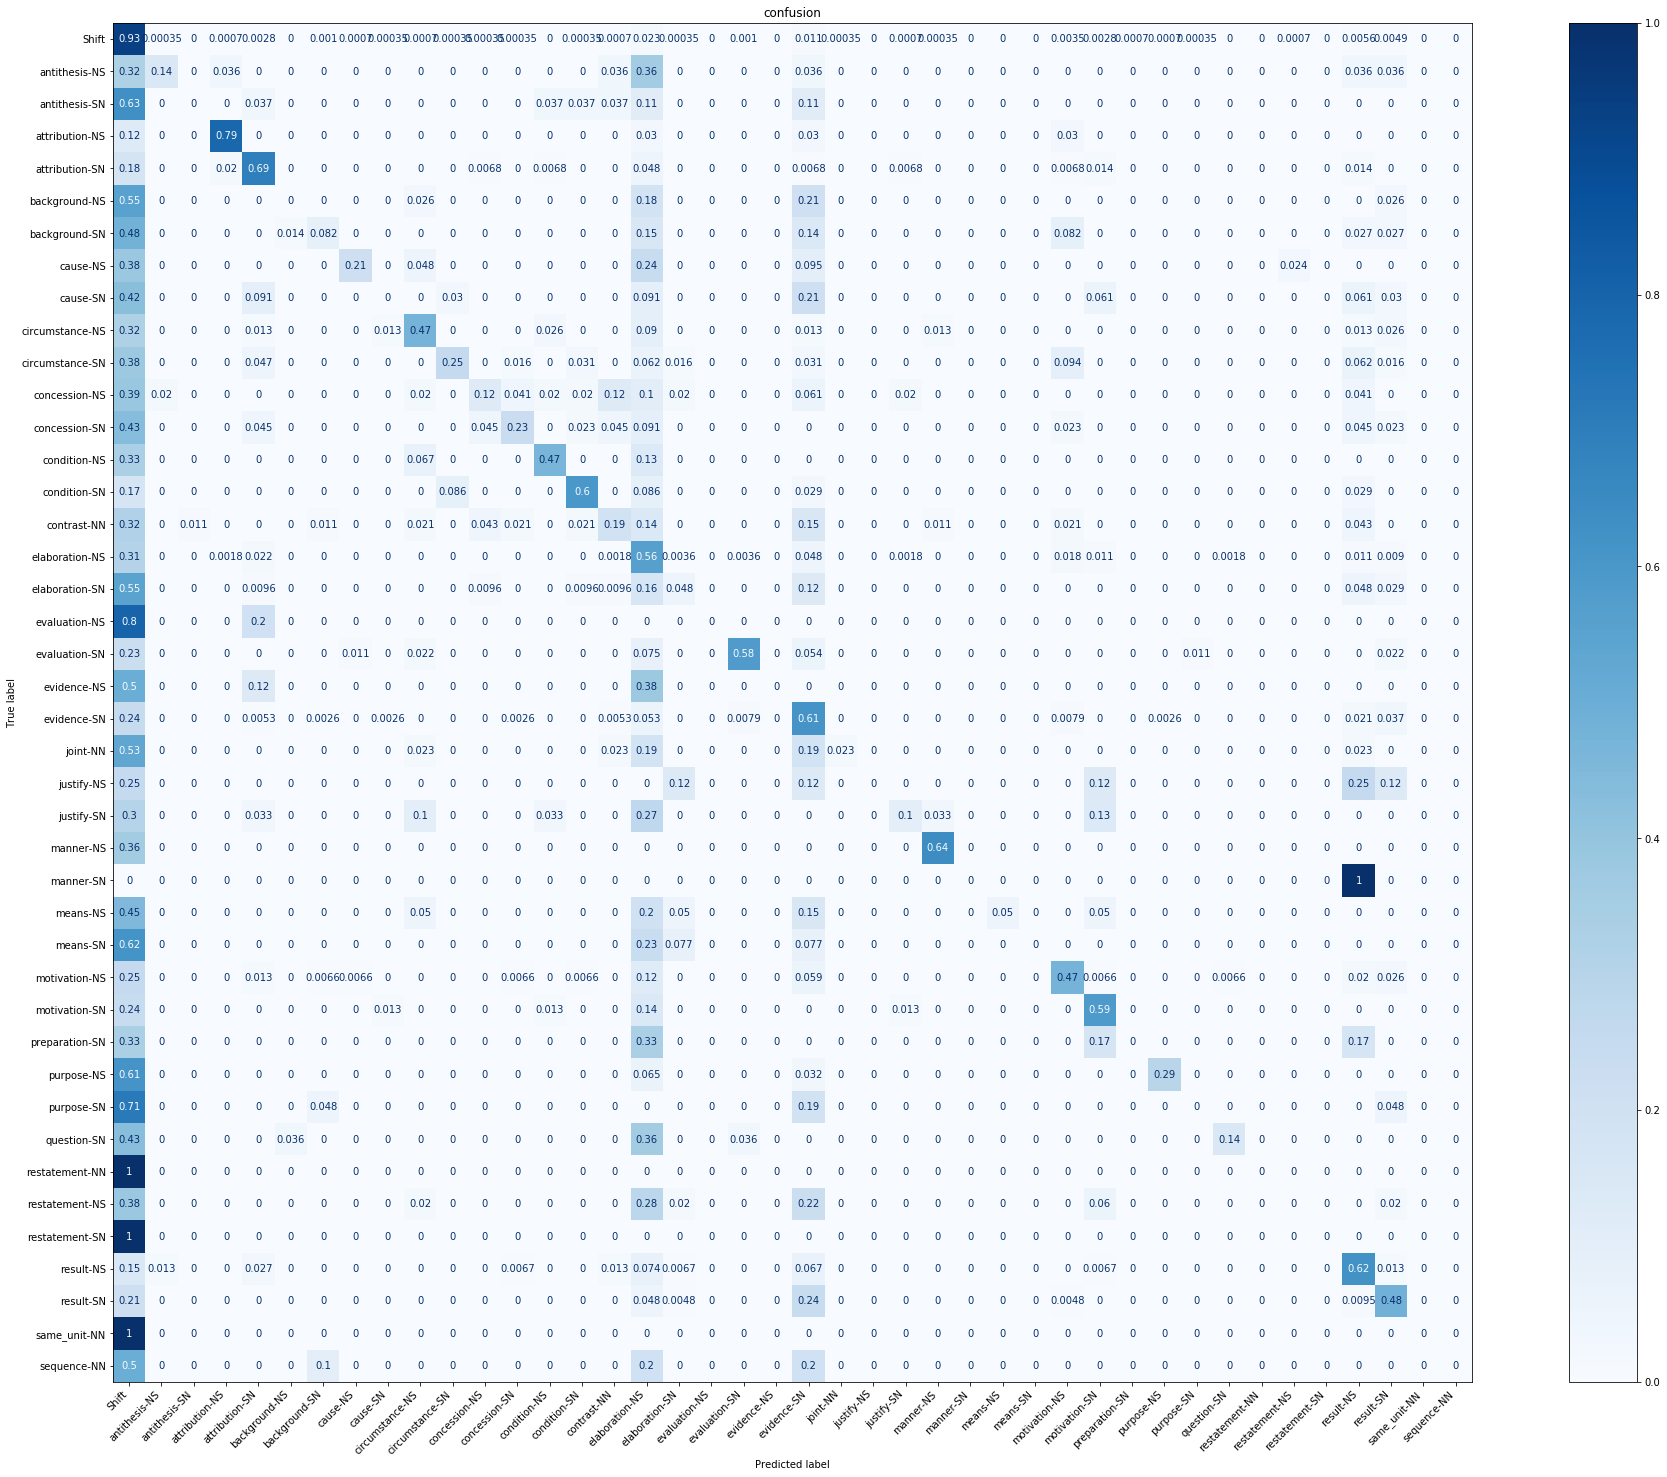

In [128]:
def report(trial):
    print(trial)
    print(classification_report(test["label"], trial.preds))
    names = get_column_names_from_ColumnTransformer(trial.transformer)
    print(names[:50])
    transformer = trial.transformer
    
    disp = plot_confusion_matrix(
        trial.model,
        transformer.transform(test),
        test['label'],
        #display_labels=test['label'].values,
        cmap=plt.cm.Blues,
        normalize='true'
    )
    plt.xticks(rotation=45, ha="right")
    disp.ax_.set_title("confusion")
    disp.figure_.set_figwidth(35)
    disp.figure_.set_figheight(25)

#report(xgb_trial)
report(xgb_with_bc)

# things we've done:
# - add top1stack to text_features
# - added brown clusters for tokens
# - whitelisted token features using pdtb, no threshold (using threshold led to degradation)
# - added augmented features
# - genre, SeqPredTop1Span, Top1-Stack
# - xgboost
# - textual features: 3000 limit for bigrams, 10000 for bc bigrams

# 2 new binary features:
# XGBTrial brown:
#   accuracy: 0.6765327695560254
#   micro_recall: 0.6765327695560254
#   macro_recall: 0.230230284329872
#   micro_f1: 0.6765327695560254
#   macro_f1: 0.2609409260189481

# bigrams:
# XGBTrial brown:
#   accuracy: 0.6837561663143058
#   micro_recall: 0.6837561663143058
#   macro_recall: 0.24760293490693278
#   micro_f1: 0.6837561663143058
#   macro_f1: 0.2771510576657067

# trigrams:
# XGBTrial brown:
#   accuracy: 0.6834038054968288
#   micro_recall: 0.6834038054968288
#   macro_recall: 0.24767309976822838
#   micro_f1: 0.6834038054968288
#   macro_f1: 0.27648584807706494
